<a href="https://colab.research.google.com/github/snigdhasaha7/diffusion-for-photoacoustic/blob/main/Week6_Snigdha_inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import sys 

# import utils from github repo
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    ! git clone https://github.com/snigdhasaha7/diffusion-for-photoacoustic.git
    sys.path.append('./diffusion-for-photoacoustic/')

fatal: destination path 'diffusion-for-photoacoustic' already exists and is not an empty directory.


In [56]:
%cd diffusion-for-photoacoustic/
! git pull

/content/diffusion-for-photoacoustic
Already up to date.


In [57]:
%cd ..

/content


In [58]:
from models import ScoreNet
from sdes import SDE
import torch
import functools
import matplotlib.pyplot as plt
from samplers import lbda_scheduler
import samplers 
import metrics
from torch.optim import Adam
import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import numpy as np
import json
import random

In [59]:
device = 'cuda'
sde_funcs = SDE(device=device)
n_epochs =  50
lr = 1e-4
batch_size=64

beta_min = 0.01
beta_max = 5
subvp_marginal_prob_std_fn = functools.partial(SDE.subvp_marginal_prob_std, beta_min=beta_min, beta_max=beta_max)
subvp_diffusion_coeff_fn = functools.partial(SDE.subvp_diffusion_coeff, beta_min=beta_min, beta_max=beta_max)
subvp_drift_coeff_fn = functools.partial(SDE.subvp_drift_coeff, beta_min=beta_min, beta_max=beta_max)

vp_marginal_prob_std_fn = functools.partial(SDE.vp_marginal_prob_std, beta_min=beta_min, beta_max=beta_max)
vp_diffusion_coeff_fn = functools.partial(SDE.vp_diffusion_coeff, beta_min=beta_min, beta_max=beta_max)
vp_drift_coeff_fn = functools.partial(SDE.vp_drift_coeff, beta_min=beta_min, beta_max=beta_max)

sigma_min=0.01
sigma_max=5
ve_marginal_prob_std_fn = functools.partial(SDE.ve_marginal_prob_std, sigma_min=sigma_min, sigma_max=sigma_max)
ve_diffusion_coeff_fn = functools.partial(SDE.ve_diffusion_coeff, sigma_min=sigma_min, sigma_max=sigma_max)

In [60]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps  
  z = torch.randn_like(x)
  std = marginal_prob_std(t=random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1,2,3)))
  return loss

Training Dataset

In [61]:
fashion_dataset = FashionMNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
fashion_data_loader = DataLoader(fashion_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

digits_dataset = MNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
digits_data_loader = DataLoader(digits_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training Code: 

In [62]:
def train(marginal_prob_std_fn, data_loader, sde="ve", dataset="fashion",device=device):
    score_model = torch.nn.DataParallel(ScoreNet(marginal_prob_std=marginal_prob_std_fn))
    score_model = score_model.to(device)
    optimizer = Adam(score_model.parameters(), lr=lr)
    tqdm_epoch = tqdm.notebook.trange(n_epochs)
    print(f'Training on {dataset} for {sde}')
    for epoch in tqdm_epoch:
        avg_loss = 0.
        num_items = 0
        for x, y in data_loader:
            x = x.to(device)    
            loss = loss_fn(score_model, x, marginal_prob_std_fn)
            optimizer.zero_grad()
            loss.backward()    
            optimizer.step()
            avg_loss += loss.item() * x.shape[0]
            num_items += x.shape[0]
        tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
        torch.save(score_model.state_dict(), 'ckpt_{}_{}.pth'.format(sde, dataset))

Train Score Models on all 3 SDEs and 2 Datasets

In [ ]:
train(ve_marginal_prob_std_fn, fashion_data_loader, "ve", "fashion")
train(subvp_marginal_prob_std_fn, fashion_data_loader, "subvp", "fashion")
train(vp_marginal_prob_std_fn, fashion_data_loader, "vp", "fashion")

train(ve_marginal_prob_std_fn, digits_data_loader, "ve", "digits")
train(subvp_marginal_prob_std_fn, digits_data_loader, "subvp", "digits")
train(vp_marginal_prob_std_fn, digits_data_loader, "vp", "digits")

InPainting transforms

In [63]:
class InPaintStripes(): 
    ''' Paints horizontal stripes into an image
    ''' 

    def __init__(self, zero_rows, img_size):
        self.zero_rows = zero_rows
        self.img_size = img_size
        A = torch.eye(img_size, device=device)
        for row in zero_rows: 
            A[row][row] = 0
        self.A = A

    def __call__(self, image): 
        ''' In paint, return in painted image''' 
        img = torch.squeeze(image)
        return torch.unsqueeze(torch.matmul(self.A,img), dim=0)

In [64]:
class InPaintPixels(): 
    ''' Blacks out certain pixels of an image
    ''' 

    def __init__(self, pixels, img_size):
        self.pixels = pixels
        self.img_size = img_size

    def __call__(self, image): 
        ''' In paint, return in painted image''' 
        img = torch.zeros(self.img_size * self.img_size)
        img.copy_(torch.squeeze(image).view(self.img_size * self.img_size))
        for pixel in self.pixels: 
            img[pixel] = 0
        return torch.unsqueeze(torch.reshape(img, (self.img_size, self.img_size)), dim=0)

Choosing random 5 images each from MNIST and FashionMNIST, add modification

In [65]:
test_batch_size = 5

fashion_test_dataset =  FashionMNIST("./data", train=False, transform=transforms.Compose([transforms.ToTensor()]),download=True)
fashion_test_data_loader = DataLoader(fashion_test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=4)

digits_test_dataset =  MNIST("./data", train=False, transform=transforms.Compose([transforms.ToTensor()]),download=True)
digits_test_data_loader = DataLoader(digits_test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=4)

In [66]:
num_steps = 500 
im_size = 28

eps=1e-3
time_steps = torch.linspace(1., eps, num_steps, device=device)

In [236]:
clean_fashion_sample = next(iter(fashion_test_data_loader))[0].to(device)
clean_digits_sample = next(iter(digits_test_data_loader))[0].to(device)

stripes_fashion_sample = torch.zeros(clean_fashion_sample.shape)
stripes_digits_sample = torch.zeros(clean_digits_sample.shape)


pixels_fashion_sample = torch.zeros(clean_fashion_sample.shape)
pixels_digits_sample = torch.zeros(clean_digits_sample.shape)

num_stripes = 5
rows = random.sample(range(0, im_size), num_stripes)
in_paint_stripes = InPaintStripes(rows, im_size)

num_pixels = 200 
pixels = random.sample(range(0, im_size * im_size), num_pixels) 
in_paint_pixels = InPaintPixels(pixels, im_size)

for i in range(test_batch_size):
    stripes_fashion_sample[i] = in_paint_stripes(clean_fashion_sample[i])
    stripes_digits_sample[i] = in_paint_stripes(clean_digits_sample[i])
    
    pixels_fashion_sample[i] = in_paint_pixels(clean_fashion_sample[i])
    pixels_digits_sample[i] = in_paint_pixels(clean_digits_sample[i])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


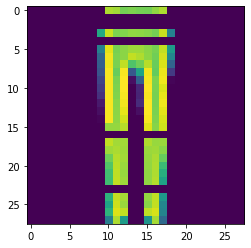

In [194]:
plt.imshow(torch.squeeze(stripes_fashion_sample[2]))

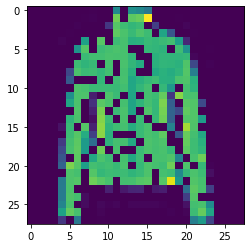

In [69]:
plt.imshow(torch.squeeze(pixels_fashion_sample[0]))

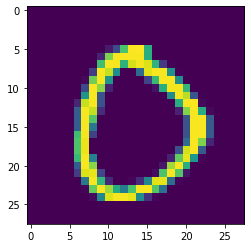

In [238]:
plt.imshow(torch.squeeze(clean_digits_sample[0]).cpu())

Set up functions and parameters for noising

In [239]:
def add_noise(x, marginal_prob_std, t): 
    t_tensor = torch.tensor([t], device=x.device) 
    std = marginal_prob_std(t_tensor)
    z = torch.randn_like(x)
    perturbed_x = x + z * std[:, None, None, None]
    return perturbed_x 

In [240]:
def noise_y(original_sample, marginal_prob_std, num_steps=num_steps, time_steps=time_steps, im_size=im_size, batch_size=test_batch_size, device=device):
    y = torch.zeros((batch_size, num_steps, 1, im_size, im_size), device=device)

    for im in range(test_batch_size):
        for step in range(num_steps): 
            y[im][step] = add_noise(original_sample[im], marginal_prob_std, t=time_steps[step])

    return y

Noising for all 3 SDES and both datasets

In [241]:
stripes_fashion_y_ve = noise_y(stripes_fashion_sample, ve_marginal_prob_std_fn)
stripes_fashion_y_subvp = noise_y(stripes_fashion_sample, subvp_marginal_prob_std_fn)
stripes_fashion_y_vp = noise_y(stripes_fashion_sample, vp_marginal_prob_std_fn)

stripes_digits_y_ve = noise_y(stripes_digits_sample, ve_marginal_prob_std_fn)
stripes_digits_y_subvp = noise_y(stripes_digits_sample, subvp_marginal_prob_std_fn)
stripes_digits_y_vp = noise_y(stripes_digits_sample, vp_marginal_prob_std_fn)

In [242]:
pixels_fashion_y_ve = noise_y(pixels_fashion_sample, ve_marginal_prob_std_fn)
pixels_fashion_y_subvp = noise_y(pixels_fashion_sample, subvp_marginal_prob_std_fn)
pixels_fashion_y_vp = noise_y(pixels_fashion_sample, vp_marginal_prob_std_fn)

pixels_digits_y_ve = noise_y(pixels_digits_sample, ve_marginal_prob_std_fn)
pixels_digits_y_subvp = noise_y(pixels_digits_sample, subvp_marginal_prob_std_fn)
pixels_digits_y_vp = noise_y(pixels_digits_sample, vp_marginal_prob_std_fn)

Conditioning

In [243]:
def pseudo_inverse(A):
    print(A)
    return torch.matmul(torch.transpose(A, 0, 1), torch.inverse(torch.matmul(A, torch.transpose(A, 0,1))))

In [244]:
def inpaint_condition(y_t, P, Lamda, T, x_t, lamda):
    y_t_flat = torch.unsqueeze(torch.flatten(y_t, start_dim=1), dim=2)
    x_t_flat = torch.unsqueeze(torch.flatten(x_t, start_dim=1), dim=2) 
    x_prime = lamda * torch.matmul(Lamda, torch.matmul(torch.inverse(P), y_t_flat))
    x_prime = x_prime + (1 - lamda) * torch.matmul(Lamda, torch.matmul(T, x_t_flat)) 
    x_prime = x_prime + torch.matmul((torch.eye(x_t_flat.shape[1], device=device) - Lamda), torch.matmul(T, x_t_flat))
    x_prime = torch.matmul(torch.inverse(T), x_prime) 
    return torch.reshape(x_prime, x_t.shape)

In [245]:
in_paint_stripes_Lamda = torch.eye(im_size*im_size, device=device)

for row in range(len(in_paint_stripes.A)):
    if in_paint_stripes.A[row][row] == 0:
        for diag in range(28*row, 28*(row+1)): 
            in_paint_stripes_Lamda[diag][diag] = 0

in_paint_pixels_Lamda = torch.eye(im_size*im_size, device=device) 
for pixel in in_paint_pixels.pixels: 
    in_paint_pixels_Lamda[pixel][pixel] = 0

in_paint_P = torch.eye(im_size*im_size,device=device) 
in_paint_T = torch.eye(im_size*im_size,device=device)

Euler Maruyama Denoiser

In [78]:
def Euler_Maruyama_denoiser(score_model, 
                           marginal_prob_std,
                           y,
                           lbda,
                           lbda_schedule,
                           diffusion_coeff, 
                           drift_coeff = None,
                           in_paint=False,
                           P=None,
                           T=None,
                           Lamda=None,
                           batch_size=64, 
                           num_steps=num_steps, 
                           device='cuda', 
                           eps=1e-3):
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 28, 28, device=device) \
    * marginal_prob_std(t)[:, None, None, None]
  # init_x = torch.unsqueeze(y[-1],dim=0)
  time_steps = torch.linspace(1., eps, num_steps, device=device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  denoised_x = [x]
  with torch.no_grad():
    for t in tqdm.notebook.tqdm(range(len(time_steps))): 
        time_step = time_steps[t]
        y_t = y[t]      
        batch_time_step = torch.ones(batch_size, device=device) * time_step
        g = diffusion_coeff(batch_time_step)
        lamda = lbda_scheduler(time_step, lbda, lbda_schedule)
        if in_paint:
            x_prime = inpaint_condition(y_t, P, Lamda, T, x, lamda)
            # print(x_prime)
        else:
            x_prime = lamda * y_t + (1 - lamda) * x
        if drift_coeff == None:
            mean_x = x_prime + (g**2)[:, None, None, None] * score_model(x_prime, batch_time_step) * step_size
        else:
            f = drift_coeff(batch_time_step, x)
            mean_x = x_prime + ( -1 * f + ((g**2)[:, None, None, None] * score_model(x_prime, batch_time_step)) ) * step_size
        x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x_prime)
        denoised_x.append(x)
  # Do not include any noise in the last sampling step.
  return denoised_x

Predictor Corrector Denoiser

In [296]:
signal_to_noise_ratio = 0.16 

def pc_denoiser(score_model, 
               marginal_prob_std,
               y,
               lbda,
               lbda_schedule,
               diffusion_coeff,
               drift_coeff=None,
               batch_size=64, 
               num_steps=num_steps, 
               snr=signal_to_noise_ratio,                
               device='cuda',
               eps=1e-3):
  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 1, 28, 28, device=device) * marginal_prob_std(t)[:, None, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  denoised_x = [x]
  with torch.no_grad():
    for t in tqdm.notebook.tqdm(range(len(time_steps))):
      time_step = time_steps[t]
      y_t = y[t]      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      lamda = lbda_scheduler(time_step, lbda, lbda_schedule)
      x_prime = lamda * y_t + (1 - lamda) * x
      if drift_coeff == None:
          x_mean = x_prime + (g**2)[:, None, None, None] * score_model(x_prime, batch_time_step) * step_size
      else:
          f = drift_coeff(batch_time_step, x)
          x_mean = x_prime + ( -1 * f + ((g**2)[:, None, None, None] * score_model(x_prime, batch_time_step)) ) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None, None] * torch.randn_like(x)      
      denoised_x.append(x)
    # The last step does not include any noise
    return denoised_x

In [256]:
score_model_ve = torch.nn.DataParallel(ScoreNet(marginal_prob_std=ve_marginal_prob_std_fn))
score_model_ve = score_model_ve.to(device)

model_pth = 'ckpt_ve_digits.pth'
ckpt = torch.load(model_pth, map_location=device)
score_model_ve.load_state_dict(ckpt)

denoiser = Euler_Maruyama_denoiser
#lamdas=torch.linspace(0.1,0,num_steps,device=device)
lbda = 0.05
lbda_schedule="linear"
## Generate samples using the specified sampler.
denoised_x = denoiser(score_model_ve, 
                  ve_marginal_prob_std_fn,
                  pixels_digits_y_ve[0],
                  lbda,
                  lbda_schedule,
                  ve_diffusion_coeff_fn, 
                  drift_coeff=None,
                  in_paint=True,
                  P=in_paint_P, 
                  T=in_paint_T, 
                  Lamda=in_paint_pixels_Lamda,
                  batch_size=1,
                  device=device)

  0%|          | 0/500 [00:00<?, ?it/s]

Metric Setup

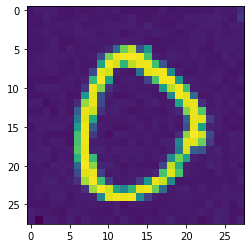

In [257]:
plt.imshow(torch.squeeze(denoised_x[499]).cpu())

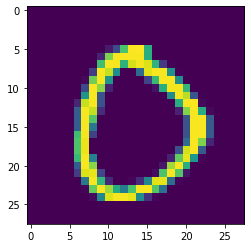

In [247]:
plt.imshow(torch.squeeze(clean_digits_sample[0]).cpu())

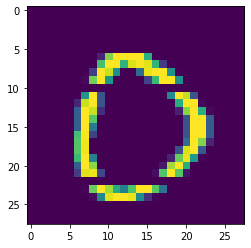

In [249]:
plt.imshow(torch.squeeze(stripes_digits_sample[0]).cpu())

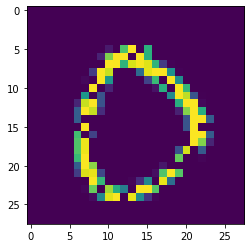

In [250]:
plt.imshow(torch.squeeze(pixels_digits_sample[0]).cpu())

In [258]:
og_image_np = torch.squeeze(clean_digits_sample[0]).cpu().detach().numpy()
denoised_image_np = torch.squeeze(denoised_x[499]).cpu().detach().numpy()
metrics.SSIM(og_image_np, denoised_image_np)

0.9493650120140797

In [ ]:
sdes = {"ve", "subvp", "vp"}
lbda_schedules = {"constant", "linear", "exponential"}
lbda=0.05

Model Loading for MNIST

In [ ]:
score_model_ve = torch.nn.DataParallel(ScoreNet(marginal_prob_std=ve_marginal_prob_std_fn))
score_model_ve = score_model_ve.to(device)
model_pth = 'ckpt_ve_digits.pth'
ckpt = torch.load(model_pth, map_location=device)
score_model_ve.load_state_dict(ckpt)

score_model_subvp = torch.nn.DataParallel(ScoreNet(marginal_prob_std=subvp_marginal_prob_std_fn))
score_model_subvp = score_model_subvp.to(device)
model_pth = 'ckpt_subvp_digits.pth'
ckpt = torch.load(model_pth, map_location=device)
score_model_subvp.load_state_dict(ckpt)

score_model_vp = torch.nn.DataParallel(ScoreNet(marginal_prob_std=vp_marginal_prob_std_fn))
score_model_vp = score_model_vp.to(device)
model_pth = 'ckpt_vp_digits.pth'
ckpt = torch.load(model_pth, map_location=device)
score_model_vp.load_state_dict(ckpt)

<All keys matched successfully>

Collect metrics on EM Denoising of MNIST

In [ ]:
denoiser = Euler_Maruyama_denoiser
em_mse_dict_digits = {"ve": {"constant": 0, "linear": 0, "exponential": 0}, "subvp": {"constant": 0, "linear": 0, "exponential": 0}, "vp":{"constant": 0, "linear": 0, "exponential": 0}} 
em_psnr_dict_digits = {"ve": {"constant": 0, "linear": 0, "exponential": 0}, "subvp": {"constant": 0, "linear": 0, "exponential": 0}, "vp":{"constant": 0, "linear": 0, "exponential": 0}} 
em_ssim_dict_digits  = {"ve": {"constant": 0, "linear": 0, "exponential": 0}, "subvp": {"constant": 0, "linear": 0, "exponential": 0}, "vp":{"constant": 0, "linear": 0, "exponential": 0}}

for sde in sdes: 
    if sde == "ve":
        score_model = score_model_ve
        y = digits_y_ve
        marginal_prob_std = ve_marginal_prob_std_fn
        diffusion_coeff = ve_diffusion_coeff_fn
        drift_coeff = None
    elif sde == "subvp":
        score_model = score_model_subvp
        y = digits_y_subvp 
        marginal_prob_std = subvp_marginal_prob_std_fn
        diffusion_coeff = subvp_diffusion_coeff_fn
        drift_coeff = subvp_drift_coeff_fn
    else:
        score_model = score_model_vp 
        y = digits_y_vp
        marginal_prob_std = vp_marginal_prob_std_fn
        diffusion_coeff = vp_diffusion_coeff_fn
        drift_coeff = vp_drift_coeff_fn
    for lbda_schedule in lbda_schedules:
        mse = 0 
        psnr = 0
        ssim = 0
        for i in range(test_batch_size):
            original_image = clean_digits_sample[i]
            denoised_x = denoiser(
                score_model,
                marginal_prob_std, 
                y[i], 
                lbda, 
                lbda_schedule, 
                diffusion_coeff,
                drift_coeff,
                batch_size=1
            )
            final_image = denoised_x[-1]
            
            og_image_np = torch.squeeze(original_image).cpu().detach().numpy()
            denoised_image_np = torch.squeeze(final_image).cpu().detach().numpy()
            mse += metrics.pixel_to_pixel_MSE(og_image_np, denoised_image_np)
            psnr += metrics.PSNR(og_image_np, denoised_image_np)
            ssim += metrics.SSIM(og_image_np, denoised_image_np)
        em_mse_dict_digits[sde][lbda_schedule] = mse / test_batch_size
        em_psnr_dict_digits[sde][lbda_schedule] = psnr / test_batch_size
        em_ssim_dict_digits[sde][lbda_schedule] = ssim / test_batch_size

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Saving EM MNIST Denoising Data for safety

In [ ]:
with open('em_mnist_mse.json', 'w') as f:
    json.dump(em_mse_dict_digits, f)

with open('em_mnist_psnr.json', 'w') as f:
    json.dump(em_psnr_dict_digits, f)

with open('em_mnist_ssim.json', 'w') as f:
    json.dump(em_ssim_dict_digits, f)

Collect Metrics on PC Denoising of MNIST

In [ ]:
denoiser = pc_denoiser
pc_mse_dict_digits = {"ve": {"constant": 0, "linear": 0, "exponential": 0}, "subvp": {"constant": 0, "linear": 0, "exponential": 0}, "vp":{"constant": 0, "linear": 0, "exponential": 0}} 
pc_psnr_dict_digits = {"ve": {"constant": 0, "linear": 0, "exponential": 0}, "subvp": {"constant": 0, "linear": 0, "exponential": 0}, "vp":{"constant": 0, "linear": 0, "exponential": 0}} 
pc_ssim_dict_digits  = {"ve": {"constant": 0, "linear": 0, "exponential": 0}, "subvp": {"constant": 0, "linear": 0, "exponential": 0}, "vp":{"constant": 0, "linear": 0, "exponential": 0}}

for sde in sdes: 
    if sde == "ve":
        score_model = score_model_ve
        y = digits_y_ve
        marginal_prob_std = ve_marginal_prob_std_fn
        diffusion_coeff = ve_diffusion_coeff_fn
        drift_coeff = None
    elif sde == "subvp":
        score_model = score_model_subvp
        y = digits_y_subvp 
        marginal_prob_std = subvp_marginal_prob_std_fn
        diffusion_coeff = subvp_diffusion_coeff_fn
        drift_coeff = subvp_drift_coeff_fn
    else:
        score_model = score_model_vp 
        y = digits_y_vp
        marginal_prob_std = vp_marginal_prob_std_fn
        diffusion_coeff = vp_diffusion_coeff_fn
        drift_coeff = vp_drift_coeff_fn
    for lbda_schedule in lbda_schedules:
        mse = 0 
        psnr = 0
        ssim = 0
        for i in range(test_batch_size):
            original_image = clean_digits_sample[i]
            denoised_x = denoiser(
                score_model,
                marginal_prob_std, 
                y[i], 
                lbda, 
                lbda_schedule, 
                diffusion_coeff,
                drift_coeff,
                batch_size=1
            )
            final_image = denoised_x[-1]
            
            og_image_np = torch.squeeze(original_image).cpu().detach().numpy()
            denoised_image_np = torch.squeeze(final_image).cpu().detach().numpy()
            mse += metrics.pixel_to_pixel_MSE(og_image_np, denoised_image_np)
            psnr += metrics.PSNR(og_image_np, denoised_image_np)
            ssim += metrics.SSIM(og_image_np, denoised_image_np)
        pc_mse_dict_digits[sde][lbda_schedule] = mse / test_batch_size
        pc_psnr_dict_digits[sde][lbda_schedule] = psnr / test_batch_size
        pc_ssim_dict_digits[sde][lbda_schedule] = ssim / test_batch_size

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Saving PC MNIST Denoising Data for Safety

In [ ]:
with open('pc_mnist_mse.json', 'w') as f:
    json.dump(pc_mse_dict_digits, f)

with open('pc_mnist_psnr.json', 'w') as f:
    json.dump(pc_psnr_dict_digits, f)

with open('pc_mnist_ssim.json', 'w') as f:
    json.dump(pc_ssim_dict_digits, f)

Model Loading for Fashion MNIST

In [ ]:
score_model_ve = torch.nn.DataParallel(ScoreNet(marginal_prob_std=ve_marginal_prob_std_fn))
score_model_ve = score_model_ve.to(device)
model_pth = 'ckpt_ve_fashion.pth'
ckpt = torch.load(model_pth, map_location=device)
score_model_ve.load_state_dict(ckpt)

score_model_subvp = torch.nn.DataParallel(ScoreNet(marginal_prob_std=subvp_marginal_prob_std_fn))
score_model_subvp = score_model_subvp.to(device)
model_pth = 'ckpt_subvp_fashion.pth'
ckpt = torch.load(model_pth, map_location=device)
score_model_subvp.load_state_dict(ckpt)

score_model_vp = torch.nn.DataParallel(ScoreNet(marginal_prob_std=vp_marginal_prob_std_fn))
score_model_vp = score_model_vp.to(device)
model_pth = 'ckpt_vp_fashion.pth'
ckpt = torch.load(model_pth, map_location=device)
score_model_vp.load_state_dict(ckpt)

<All keys matched successfully>

Collect metrics on EM Denoising of FashionMNIST

In [ ]:
denoiser = Euler_Maruyama_denoiser
em_mse_dict_fashion = {"ve": {"constant": 0, "linear": 0, "exponential": 0}, "subvp": {"constant": 0, "linear": 0, "exponential": 0}, "vp":{"constant": 0, "linear": 0, "exponential": 0}} 
em_psnr_dict_fashion = {"ve": {"constant": 0, "linear": 0, "exponential": 0}, "subvp": {"constant": 0, "linear": 0, "exponential": 0}, "vp":{"constant": 0, "linear": 0, "exponential": 0}} 
em_ssim_dict_fashion  = {"ve": {"constant": 0, "linear": 0, "exponential": 0}, "subvp": {"constant": 0, "linear": 0, "exponential": 0}, "vp":{"constant": 0, "linear": 0, "exponential": 0}}

for sde in sdes: 
    if sde == "ve":
        score_model = score_model_ve
        y = digits_y_ve
        marginal_prob_std = ve_marginal_prob_std_fn
        diffusion_coeff = ve_diffusion_coeff_fn
        drift_coeff = None
    elif sde == "subvp":
        score_model = score_model_subvp
        y = digits_y_subvp 
        marginal_prob_std = subvp_marginal_prob_std_fn
        diffusion_coeff = subvp_diffusion_coeff_fn
        drift_coeff = subvp_drift_coeff_fn
    else:
        score_model = score_model_vp 
        y = digits_y_vp
        marginal_prob_std = vp_marginal_prob_std_fn
        diffusion_coeff = vp_diffusion_coeff_fn
        drift_coeff = vp_drift_coeff_fn
    for lbda_schedule in lbda_schedules:
        mse = 0 
        psnr = 0
        ssim = 0
        for i in range(test_batch_size):
            original_image = clean_digits_sample[i]
            denoised_x = denoiser(
                score_model,
                marginal_prob_std, 
                y[i], 
                lbda, 
                lbda_schedule, 
                diffusion_coeff,
                drift_coeff,
                batch_size=1
            )
            final_image = denoised_x[-1]
            
            og_image_np = torch.squeeze(original_image).cpu().detach().numpy()
            denoised_image_np = torch.squeeze(final_image).cpu().detach().numpy()
            mse += metrics.pixel_to_pixel_MSE(og_image_np, denoised_image_np)
            psnr += metrics.PSNR(og_image_np, denoised_image_np)
            ssim += metrics.SSIM(og_image_np, denoised_image_np)
        em_mse_dict_fashion[sde][lbda_schedule] = mse / test_batch_size
        em_psnr_dict_fashion[sde][lbda_schedule] = psnr / test_batch_size
        em_ssim_dict_fashion[sde][lbda_schedule] = ssim / test_batch_size

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Saving EM FashionMNIST Data for Safety

In [ ]:
with open('em_fashion_mse.json', 'w') as f:
    json.dump(em_mse_dict_fashion, f)

with open('em_fashion_psnr.json', 'w') as f:
    json.dump(em_psnr_dict_fashion, f)

with open('em_fashion_ssim.json', 'w') as f:
    json.dump(em_ssim_dict_fashion, f)

Collect Metrics on PC Denoising of FashionMNIST

In [ ]:
denoiser = pc_denoiser
pc_mse_dict_fashion = {"ve": {"constant": 0, "linear": 0, "exponential": 0}, "subvp": {"constant": 0, "linear": 0, "exponential": 0}, "vp":{"constant": 0, "linear": 0, "exponential": 0}} 
pc_psnr_dict_fashion = {"ve": {"constant": 0, "linear": 0, "exponential": 0}, "subvp": {"constant": 0, "linear": 0, "exponential": 0}, "vp":{"constant": 0, "linear": 0, "exponential": 0}} 
pc_ssim_dict_fashion  = {"ve": {"constant": 0, "linear": 0, "exponential": 0}, "subvp": {"constant": 0, "linear": 0, "exponential": 0}, "vp":{"constant": 0, "linear": 0, "exponential": 0}}

for sde in sdes: 
    if sde == "ve":
        score_model = score_model_ve
        y = digits_y_ve
        marginal_prob_std = ve_marginal_prob_std_fn
        diffusion_coeff = ve_diffusion_coeff_fn
        drift_coeff = None
    elif sde == "subvp":
        score_model = score_model_subvp
        y = digits_y_subvp 
        marginal_prob_std = subvp_marginal_prob_std_fn
        diffusion_coeff = subvp_diffusion_coeff_fn
        drift_coeff = subvp_drift_coeff_fn
    else:
        score_model = score_model_vp 
        y = digits_y_vp
        marginal_prob_std = vp_marginal_prob_std_fn
        diffusion_coeff = vp_diffusion_coeff_fn
        drift_coeff = vp_drift_coeff_fn
    for lbda_schedule in lbda_schedules:
        mse = 0 
        psnr = 0
        ssim = 0
        for i in range(test_batch_size):
            original_image = clean_digits_sample[i]
            denoised_x = denoiser(
                score_model,
                marginal_prob_std, 
                y[i], 
                lbda, 
                lbda_schedule, 
                diffusion_coeff,
                drift_coeff,
                batch_size=1
            )
            final_image = denoised_x[-1]
            
            og_image_np = torch.squeeze(original_image).cpu().detach().numpy()
            denoised_image_np = torch.squeeze(final_image).cpu().detach().numpy()
            mse += metrics.pixel_to_pixel_MSE(og_image_np, denoised_image_np)
            psnr += metrics.PSNR(og_image_np, denoised_image_np)
            ssim += metrics.SSIM(og_image_np, denoised_image_np)
        pc_mse_dict_fashion[sde][lbda_schedule] = mse / test_batch_size
        pc_psnr_dict_fashion[sde][lbda_schedule] = psnr / test_batch_size
        pc_ssim_dict_fashion[sde][lbda_schedule] = ssim / test_batch_size

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Saving PC FashionMNIST Data for Safety

In [ ]:
with open('pc_fashion_mse.json', 'w') as f:
    json.dump(pc_mse_dict_fashion, f)

with open('pc_fashion_psnr.json', 'w') as f:
    json.dump(pc_psnr_dict_fashion, f)

with open('pc_fashion_ssim.json', 'w') as f:
    json.dump(pc_ssim_dict_fashion, f)

# Visualize all EM MNIST Data



MSE

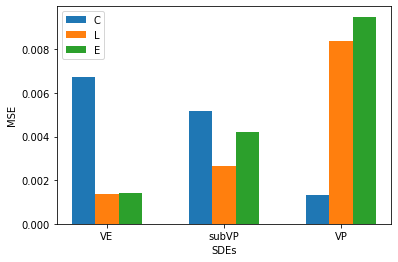

In [ ]:
constant = [em_mse_dict_digits["ve"]["constant"], em_mse_dict_digits["subvp"]["constant"], em_mse_dict_digits["vp"]["constant"]]
linear = [em_mse_dict_digits["ve"]["linear"], em_mse_dict_digits["subvp"]["linear"], em_mse_dict_digits["vp"]["linear"]]
exponential = [em_mse_dict_digits["ve"]["exponential"], em_mse_dict_digits["subvp"]["exponential"], em_mse_dict_digits["vp"]["exponential"]]

x = np.arange(3)
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, constant, width)
plt.bar(x, linear, width)
plt.bar(x+0.2, exponential, width)
plt.xticks(x, ['VE', 'subVP', 'VP'])
plt.xlabel("SDEs")
plt.ylabel("MSE")
plt.legend(["C", "L", "E"])
plt.show()

PSNR

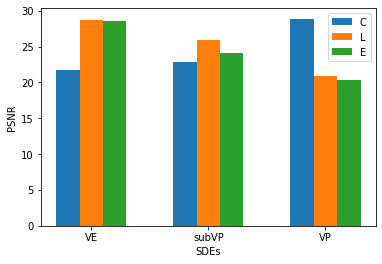

In [ ]:
constant = [em_psnr_dict_digits["ve"]["constant"], em_psnr_dict_digits["subvp"]["constant"], em_psnr_dict_digits["vp"]["constant"]]
linear = [em_psnr_dict_digits["ve"]["linear"], em_psnr_dict_digits["subvp"]["linear"], em_psnr_dict_digits["vp"]["linear"]]
exponential = [em_psnr_dict_digits["ve"]["exponential"], em_psnr_dict_digits["subvp"]["exponential"], em_psnr_dict_digits["vp"]["exponential"]]

x = np.arange(3)
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, constant, width)
plt.bar(x, linear, width)
plt.bar(x+0.2, exponential, width)
plt.xticks(x, ['VE', 'subVP', 'VP'])
plt.xlabel("SDEs")
plt.ylabel("PSNR")
plt.legend(["C", "L", "E"])
plt.show()

SSIM

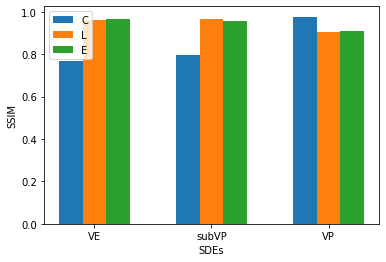

In [ ]:
constant = [em_ssim_dict_digits["ve"]["constant"], em_ssim_dict_digits["subvp"]["constant"], em_ssim_dict_digits["vp"]["constant"]]
linear = [em_ssim_dict_digits["ve"]["linear"], em_ssim_dict_digits["subvp"]["linear"], em_ssim_dict_digits["vp"]["linear"]]
exponential = [em_ssim_dict_digits["ve"]["exponential"], em_ssim_dict_digits["subvp"]["exponential"], em_ssim_dict_digits["vp"]["exponential"]]

x = np.arange(3)
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, constant, width)
plt.bar(x, linear, width)
plt.bar(x+0.2, exponential, width)
plt.xticks(x, ['VE', 'subVP', 'VP'])
plt.xlabel("SDEs")
plt.ylabel("SSIM")
plt.legend(["C", "L", "E"])
plt.show()

# Visualize all PC MNIST Data

MSE

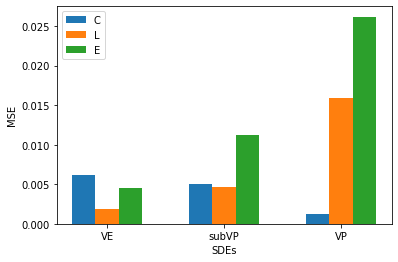

In [ ]:
constant = [pc_mse_dict_digits["ve"]["constant"], pc_mse_dict_digits["subvp"]["constant"], pc_mse_dict_digits["vp"]["constant"]]
linear = [pc_mse_dict_digits["ve"]["linear"], pc_mse_dict_digits["subvp"]["linear"], pc_mse_dict_digits["vp"]["linear"]]
exponential = [pc_mse_dict_digits["ve"]["exponential"], pc_mse_dict_digits["subvp"]["exponential"], pc_mse_dict_digits["vp"]["exponential"]]

x = np.arange(3)
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, constant, width)
plt.bar(x, linear, width)
plt.bar(x+0.2, exponential, width)
plt.xticks(x, ['VE', 'subVP', 'VP'])
plt.xlabel("SDEs")
plt.ylabel("MSE")
plt.legend(["C", "L", "E"])
plt.show()

PSNR

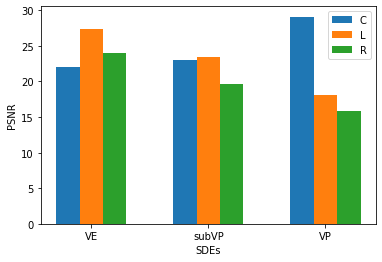

In [ ]:
constant = [pc_psnr_dict_digits["ve"]["constant"], pc_psnr_dict_digits["subvp"]["constant"], pc_psnr_dict_digits["vp"]["constant"]]
linear = [pc_psnr_dict_digits["ve"]["linear"], pc_psnr_dict_digits["subvp"]["linear"], pc_psnr_dict_digits["vp"]["linear"]]
exponential = [pc_psnr_dict_digits["ve"]["exponential"], pc_psnr_dict_digits["subvp"]["exponential"], pc_psnr_dict_digits["vp"]["exponential"]]

x = np.arange(3)
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, constant, width)
plt.bar(x, linear, width)
plt.bar(x+0.2, exponential, width)
plt.xticks(x, ['VE', 'subVP', 'VP'])
plt.xlabel("SDEs")
plt.ylabel("PSNR")
plt.legend(["C", "L", "R"])
plt.show()

SSIM

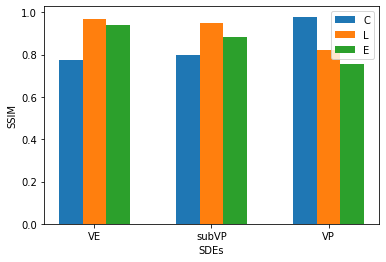

In [ ]:
constant = [pc_ssim_dict_digits["ve"]["constant"], pc_ssim_dict_digits["subvp"]["constant"], pc_ssim_dict_digits["vp"]["constant"]]
linear = [pc_ssim_dict_digits["ve"]["linear"], pc_ssim_dict_digits["subvp"]["linear"], pc_ssim_dict_digits["vp"]["linear"]]
exponential = [pc_ssim_dict_digits["ve"]["exponential"], pc_ssim_dict_digits["subvp"]["exponential"], pc_ssim_dict_digits["vp"]["exponential"]]

x = np.arange(3)
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, constant, width)
plt.bar(x, linear, width)
plt.bar(x+0.2, exponential, width)
plt.xticks(x, ['VE', 'subVP', 'VP'])
plt.xlabel("SDEs")
plt.ylabel("SSIM")
plt.legend(["C", "L", "E"])
plt.show()

# Visualize all EM FashionMNIST Data

MSE

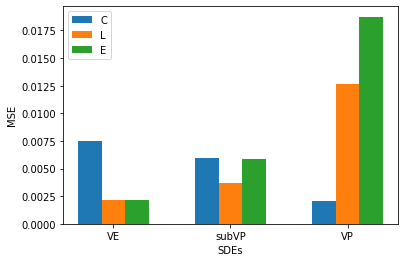

In [ ]:
constant = [em_mse_dict_fashion["ve"]["constant"], em_mse_dict_fashion["subvp"]["constant"], em_mse_dict_fashion["vp"]["constant"]]
linear = [em_mse_dict_fashion["ve"]["linear"], em_mse_dict_fashion["subvp"]["linear"], em_mse_dict_fashion["vp"]["linear"]]
exponential = [em_mse_dict_fashion["ve"]["exponential"], em_mse_dict_fashion["subvp"]["exponential"], em_mse_dict_fashion["vp"]["exponential"]]

x = np.arange(3)
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, constant, width)
plt.bar(x, linear, width)
plt.bar(x+0.2, exponential, width)
plt.xticks(x, ['VE', 'subVP', 'VP'])
plt.xlabel("SDEs")
plt.ylabel("MSE")
plt.legend(["C", "L", "E"])
plt.show()

PSNR

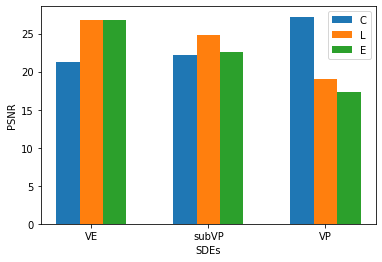

In [ ]:
constant = [em_psnr_dict_fashion["ve"]["constant"], em_psnr_dict_fashion["subvp"]["constant"], em_psnr_dict_fashion["vp"]["constant"]]
linear = [em_psnr_dict_fashion["ve"]["linear"], em_psnr_dict_fashion["subvp"]["linear"], em_psnr_dict_fashion["vp"]["linear"]]
exponential = [em_psnr_dict_fashion["ve"]["exponential"], em_psnr_dict_fashion["subvp"]["exponential"], em_psnr_dict_fashion["vp"]["exponential"]]

x = np.arange(3)
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, constant, width)
plt.bar(x, linear, width)
plt.bar(x+0.2, exponential, width)
plt.xticks(x, ['VE', 'subVP', 'VP'])
plt.xlabel("SDEs")
plt.ylabel("PSNR")
plt.legend(["C", "L", "E"])
plt.show()

SSIM

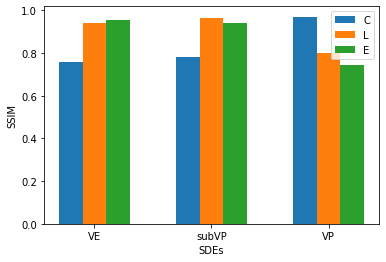

In [ ]:
constant = [em_ssim_dict_fashion["ve"]["constant"], em_ssim_dict_fashion["subvp"]["constant"], em_ssim_dict_fashion["vp"]["constant"]]
linear = [em_ssim_dict_fashion["ve"]["linear"], em_ssim_dict_fashion["subvp"]["linear"], em_ssim_dict_fashion["vp"]["linear"]]
exponential = [em_ssim_dict_fashion["ve"]["exponential"], em_ssim_dict_fashion["subvp"]["exponential"], em_ssim_dict_fashion["vp"]["exponential"]]

x = np.arange(3)
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, constant, width)
plt.bar(x, linear, width)
plt.bar(x+0.2, exponential, width)
plt.xticks(x, ['VE', 'subVP', 'VP'])
plt.xlabel("SDEs")
plt.ylabel("SSIM")
plt.legend(["C", "L", "E"])
plt.show()

# Visualize all PC FashionMNIST Data

MSE

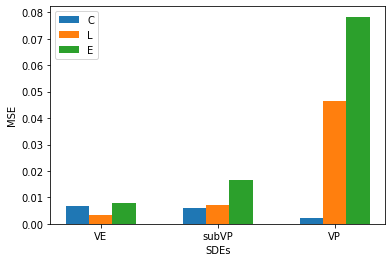

In [ ]:
constant = [pc_mse_dict_fashion["ve"]["constant"], pc_mse_dict_fashion["subvp"]["constant"], pc_mse_dict_fashion["vp"]["constant"]]
linear = [pc_mse_dict_fashion["ve"]["linear"], pc_mse_dict_fashion["subvp"]["linear"], pc_mse_dict_fashion["vp"]["linear"]]
exponential = [pc_mse_dict_fashion["ve"]["exponential"], pc_mse_dict_fashion["subvp"]["exponential"], pc_mse_dict_fashion["vp"]["exponential"]]

x = np.arange(3)
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, constant, width)
plt.bar(x, linear, width)
plt.bar(x+0.2, exponential, width)
plt.xticks(x, ['VE', 'subVP', 'VP'])
plt.xlabel("SDEs")
plt.ylabel("MSE")
plt.legend(["C", "L", "E"])
plt.show()

PSNR

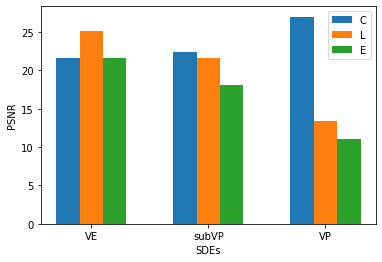

In [ ]:
constant = [pc_psnr_dict_fashion["ve"]["constant"], pc_psnr_dict_fashion["subvp"]["constant"], pc_psnr_dict_fashion["vp"]["constant"]]
linear = [pc_psnr_dict_fashion["ve"]["linear"], pc_psnr_dict_fashion["subvp"]["linear"], pc_psnr_dict_fashion["vp"]["linear"]]
exponential = [pc_psnr_dict_fashion["ve"]["exponential"], pc_psnr_dict_fashion["subvp"]["exponential"], pc_psnr_dict_fashion["vp"]["exponential"]]

x = np.arange(3)
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, constant, width)
plt.bar(x, linear, width)
plt.bar(x+0.2, exponential, width)
plt.xticks(x, ['VE', 'subVP', 'VP'])
plt.xlabel("SDEs")
plt.ylabel("PSNR")
plt.legend(["C", "L", "E"])
plt.show()

SSIM

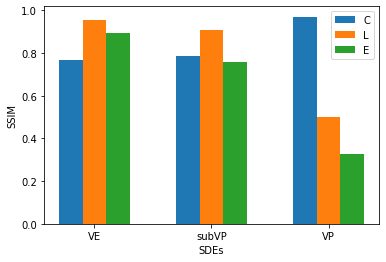

In [ ]:
constant = [pc_ssim_dict_fashion["ve"]["constant"], pc_ssim_dict_fashion["subvp"]["constant"], pc_ssim_dict_fashion["vp"]["constant"]]
linear = [pc_ssim_dict_fashion["ve"]["linear"], pc_ssim_dict_fashion["subvp"]["linear"], pc_ssim_dict_fashion["vp"]["linear"]]
exponential = [pc_ssim_dict_fashion["ve"]["exponential"], pc_ssim_dict_fashion["subvp"]["exponential"], pc_ssim_dict_fashion["vp"]["exponential"]]

x = np.arange(3)
width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, constant, width)
plt.bar(x, linear, width)
plt.bar(x+0.2, exponential, width)
plt.xticks(x, ['VE', 'subVP', 'VP'])
plt.xlabel("SDEs")
plt.ylabel("SSIM")
plt.legend(["C", "L", "E"])
plt.show()